In [182]:

from xbbg import blp
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from datetime import timedelta

vector = ["EURUSD CURNCY", "GBPUSD CURNCY","AUDUSD CURNCY","USDJPY CURNCY","CO1 COMDTY", "TZT1 COMDTY", "USGG2Y INDEX",
          "USGG10Y INDEX", "ES1 INDEX", "SX5E INDEX", "GDBR2 INDEX",
         "GDBR10 INDEX", "USDZAR CURNCY", "USDCNH CURNCY", "XAUUSD CURNCY", "HG1 COMDTY", "UX1 INDEX"]
log_flag = [True, True, True, True, True, True, False, False, True, True, False, False, True, True, True, True, False]
end=datetime.date.today()
start=datetime.date.today()-timedelta(days = 180)

data = blp.bdh(vector, 'LAST_PRICE', start,end)
data = data.dropna()

for k in range(0, len(log_flag)):
            if log_flag[k] == True:
                data.iloc[:,k] = data.iloc[:,k].apply(lambda x: np.log(x)*100)

data = data-data.shift(1)
data.dropna(inplace = True)
cols = data.columns
rename = []
for element in cols:
    rename.append(element[0])
data.columns = rename
                
print(data)
#print(data.shift(1))

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['savefig.facecolor']='white'

            EURUSD CURNCY  GBPUSD CURNCY  AUDUSD CURNCY  USDJPY CURNCY  \
2022-06-28      -0.616028      -0.662606      -0.260229       0.500737   
2022-06-29      -0.734701      -0.493666      -0.406151       0.329997   
2022-06-30       0.401415       0.444409       0.333745      -0.638980   
2022-07-01      -0.669923      -0.683890      -1.297678      -0.376481   
2022-07-05      -1.431359      -1.231194      -0.176263       0.472221   
...                   ...            ...            ...            ...   
2022-12-16      -0.395965      -0.246650      -0.268898      -0.860126   
2022-12-19       0.198179       0.008231       0.224132       0.226683   
2022-12-20       0.160143       0.279468      -0.328898      -3.856940   
2022-12-21      -0.179000      -0.832480       0.433322       0.552634   
2022-12-22      -0.084902      -0.364843      -0.553190      -0.083078   

            CO1 COMDTY  TZT1 COMDTY  USGG2Y INDEX  USGG10Y INDEX  ES1 INDEX  \
2022-06-28    2.480069    -0.218

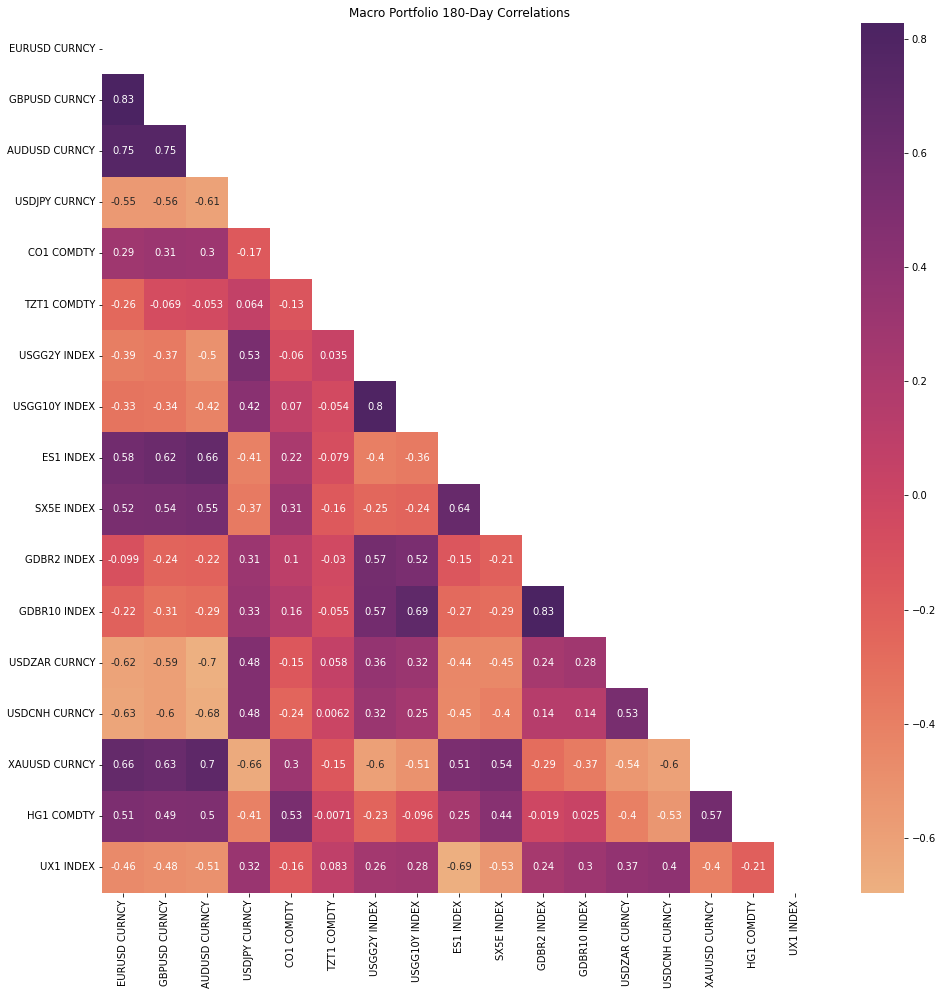

In [203]:
plt.figure(figsize=(16,16))
plt.title("Macro Portfolio 180-Day Correlations")

mask = np.triu(np.ones_like(data.corr(), dtype=bool))

sns.heatmap(data = data.corr(), mask = mask, annot = True, cmap = "flare")
plt.show()

In [188]:
def pca_rollingcorr(tickers, log_flags, window, lookback, cumulative):
    pc1_corr = []
    pc2_corr = []
    pc3_corr = []
    pc4_corr = []
    dates = []

    data_pull = blp.bdh(tickers, 'LAST_PRICE', datetime.date.today()-timedelta(days = window + lookback), datetime.date.today())
    cols = data_pull.columns
    rename = []
    for element in cols:
        rename.append(element[0])
    data_pull.columns = rename
    
    #print(data_pull)
    for day_shift in range(0, lookback):
        end_date = datetime.date.today()-timedelta(days = day_shift)
        start_date = end_date-timedelta(days = window)
        vec = data_pull[(data_pull.index>=start_date) & (data_pull.index<=end_date)]
        #print(vec.iloc[:,0])
        for k in range(0, len(log_flags)):
            if log_flags[k] == True:
                vec.iloc[:,k] = vec.iloc[:,k].apply(lambda x: np.log(x)*100)

        vec = vec-vec.shift(1)
        vec.dropna(inplace = True)

        
        #print(vec)
        scaler = StandardScaler()
        vec_scaled = pd.DataFrame(scaler.fit_transform(vec), columns = vec.columns)
        n = vec_scaled.shape[1]
        pca = PCA(n_components = n, random_state = 1)
        pca_fitted = pca.fit_transform(vec_scaled)
        pca_dframe = pd.DataFrame(data = pca_fitted)
        
        exp_var = pca.explained_variance_ratio_
        pc1_corr.append(exp_var[0])
        pc2_corr.append(exp_var[1])
        pc3_corr.append(exp_var[2])
        pc4_corr.append(exp_var[3])
        dates.append(end_date)
        

    #print(dates, pc1_corr, pc2_corr)
    plt.figure(figsize = (12,12))
    plt.gca().set_facecolor("white")
    plt.title("Macro Portfolio PCA Dispersion\n%s-Day Sample, %s-Day Lookback"%(window, lookback))
    plt.xlabel("Date")
    plt.ylabel("Explained Variance Percentage")
    sns.lineplot(x = dates, y = pc1_corr, label = "Component_1", color = "Red")
    sns.lineplot(x = dates, y = pc2_corr, label = "Component_2", color = "Blue")
    sns.lineplot(x = dates, y = pc3_corr, label = "Component_3", color = "Green")
    
    today = datetime.date.today()
    cumul_lookback = today - timedelta(days = cumulative)
    
    vec2 =  data_pull[(data_pull.index>=cumul_lookback) & (data_pull.index<=today)]
    scaler2 = StandardScaler()
    vec2_scaled = pd.DataFrame(scaler2.fit_transform(vec2), columns = vec2.columns)
    q = vec2_scaled.shape[1]
    pca2 = PCA(n_components = q, random_state = 1)
    pca2_fitted = pca2.fit_transform(vec_scaled)
    pca2_dframe = pd.DataFrame(data = pca2_fitted)
    print(vec2)
    pcols = ["Comp1", "Comp2", "Comp3"]

    pca2_loadings = pd.DataFrame(np.round(pca2.components_[:3, :],2)   , index = pcols, columns = vec2.columns)

    def color_high(val):
        if val<=-0.3:
            return "background:pink"
        if val>=0.3:
            return "background:skyblue"
    display(pca2_loadings.T.style.applymap(color_high))

            EURUSD CURNCY  GBPUSD CURNCY  AUDUSD CURNCY  USDJPY CURNCY  \
2021-12-28         1.1310         1.3434         0.7229         114.82   
2021-12-29         1.1349         1.3490         0.7250         114.95   
2021-12-30         1.1325         1.3499         0.7256         115.08   
2021-12-31         1.1370         1.3532         0.7263         115.08   
2022-01-03         1.1297         1.3480         0.7190         115.32   
...                   ...            ...            ...            ...   
2022-12-19         1.0607         1.2149         0.6700         136.91   
2022-12-20         1.0624         1.2183         0.6678         131.73   
2022-12-21         1.0605         1.2082         0.6707         132.46   
2022-12-22         1.0596         1.2038         0.6670         132.35   
2022-12-23         1.0611         1.2037         0.6687         132.89   

            CO1 COMDTY  TZT1 COMDTY  USGG2Y INDEX  USGG10Y INDEX  ES1 INDEX  \
2021-12-28       78.94      106.

,Comp1,Comp2,Comp3
EURUSD CURNCY,0.040000,0.430000,0.170000
GBPUSD CURNCY,-0.030000,0.340000,0.340000
AUDUSD CURNCY,0.000000,0.420000,-0.220000
USDJPY CURNCY,-0.360000,-0.100000,-0.110000
CO1 COMDTY,-0.180000,-0.200000,-0.140000
TZT1 COMDTY,-0.130000,-0.070000,0.220000
USGG2Y INDEX,-0.400000,-0.060000,0.050000
USGG10Y INDEX,-0.380000,-0.090000,0.060000
ES1 INDEX,-0.320000,0.160000,-0.340000
SX5E INDEX,-0.320000,0.070000,-0.030000


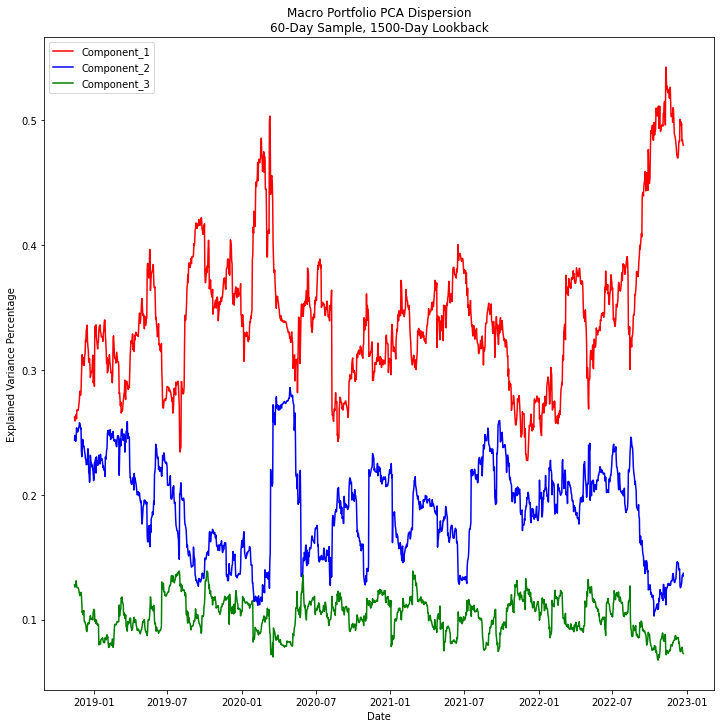

In [189]:
pca_rollingcorr(vector, log_flag, 60, 1500, 360)